In [217]:
import numpy as np
import scipy.sparse as sp
from scipy.sparse import linalg
import matplotlib.pyplot as plt
from matplotlib import pyplot, image
from scipy import ndimage
import scipy as s
import random as ran


def loader(): #just load everything important
    alpha = np.load(r'C:\Users\Mega Potato\Desktop\hs_tomography\alphas_195.npy')
    y = np.load(r'C:\Users\Mega Potato\Desktop\hs_tomography\y_195.npy')
    x_example = np.load(r'C:\Users\Mega Potato\Desktop\hs_tomography\x_example.npy')
    alpha = np.deg2rad(alpha)
    return alpha, y, x_example

def construct_X(M, alpha, Np = None):
    if Np == None: #determine Np for case if no Np is given
        Np = int(round(np.sqrt(2)*M,0))
        if np.mod(Np,2) == 0:
            Np += 1
    
    n = np.array([np.cos(alpha), np.sin(alpha)]) 
    C = (np.mgrid[0:M,0:M]-M//2).reshape((2,M**2))
    p_x = np.matmul(np.transpose(n),C) + np.floor(Np/2)  #projection of rotated lattices to x_axis
    floor = np.floor(p_x) #round all p_x down
    prob_1 = 1 + floor - p_x #calc the probs for all detector cells
    prob_2 = 1-prob_1
    detec_1 = np.transpose(np.transpose(floor) + np.arange(len(alpha))*Np)  #calc the position of detector cell and already include Np*np.arange(len(alpha)) offset for each angle 
    detec_2 = np.transpose(np.transpose(floor+1) + np.arange(len(alpha))*Np)
    x_index = np.concatenate((detec_1.flatten(),detec_2.flatten())) #concatenate values for upper and lower detectorcells
    y_index = np.mgrid[0:2*len(alpha), 0:M**2][1].flatten() #stack range(0,M**2) 2*len(alpha) successionally
    indices = x_index < Np*len(alpha)
    res = np.concatenate((prob_1.flatten(), prob_2.flatten()))[indices] #create data array and drop every indices which don't hit the detector cells
    x_index, y_index = x_index[indices], y_index[indices]
    X = sp.coo_matrix((res,(x_index,y_index)),shape=(Np*len(alpha),M**2),dtype=np.float64).tocsc()
    return X.tocsc()

(45, 100)

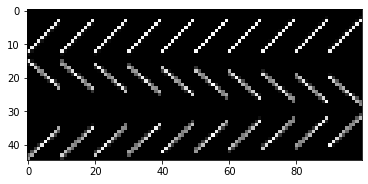

In [168]:

#Test the code
test_X = construct_X(10,[-33,1,42])
test_X = test_X.todense()
plt.imshow(test_X)
plt.gray()
np.shape(test_X)
    
#code seems fine

In [214]:
alpha, y, x_example = loader() #load everything up
X = construct_X(195, alpha, 275)

In [208]:
#check density of X

density = X.getnnz() / np.prod(X.shape)
print('Density of X is: ', density*100, '%')

Density of X is:  0.7272727272727273 %


In [209]:
#solve linear System with scipy lsqr algorithm
img = sp.linalg.lsqr(X,y, atol=1e-06,btol=1e-06)

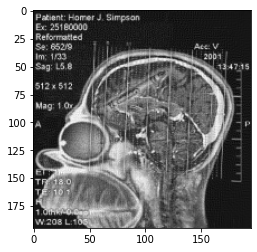

In [210]:
#plot result
img_final=img[0].reshape(195,195)
tr = s.ndimage.rotate(img_final,90)
plt.imshow(tr)

Now one can see why Homer has headache: There's a pen in his head.

In [240]:
def minimizing_rad(M, alpha, n, Np): 
    i =np.arange(0,len(alpha),len(alpha)//n) #pick evenly distributed angles from alpha
    alpha_new = alpha[i]
    y_index=(np.mgrid[0:len(alpha_new),0:275][1].T+i*275).T.flatten() #pick for each angle the corresponding response
    y_new=y[y_index]
    X = construct_X(195, alpha_new, 275) #calcs and fits as above
    img = sp.linalg.lsqr(X,y_new, atol=1e-04,btol=1e-04)
    img_final=img[0].reshape(195,195)
    tr = s.ndimage.rotate(img_final,90)
    plt.title(str(len(alpha_new)) + ' angles')
    plt.imshow(tr)
    plt.show()

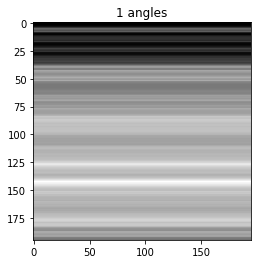

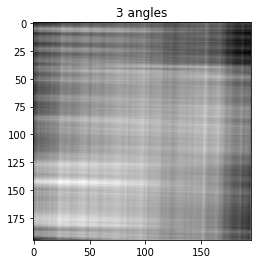

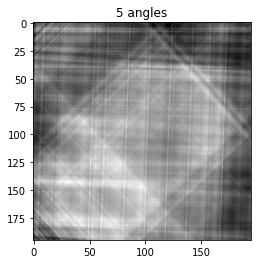

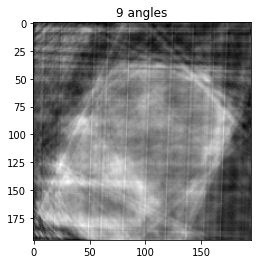

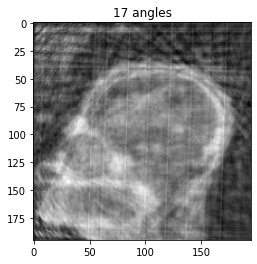

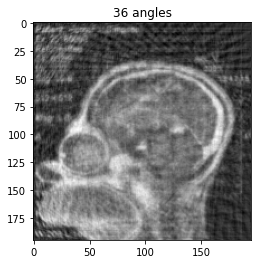

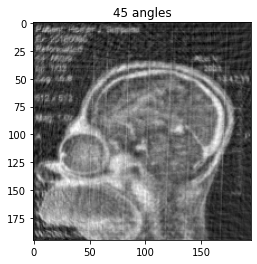

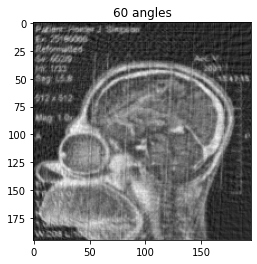

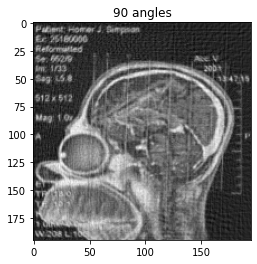

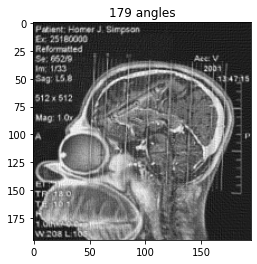

In [242]:
angles = [1,2,4,8,16,32, 40, 50,64,128] #create array of angles
for angle in angles:
    minimizing_rad(195, alpha, angle, 275)

From 60 angles on you can recognize that something is in Homer's head. From 90 angles you can clearly see it's a pen. Therefor the radiation dosage can be cut in half without big loss of resolution.